In [49]:
from typing import Any
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [50]:
X, Y = make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=0.4, random_state=0)

In [74]:
class Hypersphere():
    def __init__(self, center: np.ndarray, center_indice: int, eta_indice: int, eta: np.ndarray, radius: np.floating[Any]):
        self.center = center
        # 同じサブサンプル内の最近傍点
        self.eta = eta
        self.radius = radius
        # INNEのfit時に与えられたデータセットの中でのインデックス
        self.center_indice = center_indice
        self.eta_indice = eta_indice

class INNE():
    def __init__(self, n_estimators: int, phai: int):
        self.n_estimators = n_estimators
        # 1 estimatorあたりのサンプル数
        self.phai = phai
        # phai個の超球を含む集合を、n_estimators個含む集合
        self.estimators = []
        # 学習に使ったデータセットを保持しておく. predictでも使うため
        self.X = None
    
    def _calc_nn(self, c: np.ndarray, Si: np.ndarray, indices: np.ndarray) -> tuple[np.ndarray, int, np.floating[Any]]:
        """
        c: 超球の中心
        Si: i番目のサブサンプル
        """
        nn, nn_indice, nn_norm = None, None, None
        for x, indice in zip(Si, indices):
            distance = np.linalg.norm(c - x)
            # 自分自身を除く
            if distance == 0:
                continue

            if nn is None or nn_norm is None:
                nn = x
                nn_indice = indice
                nn_norm = np.linalg.norm(c - x)
            else:
                if distance < nn_norm:
                    nn = x
                    nn_indice = indice
                    nn_norm = np.linalg.norm(c - x)

        if nn is None or nn_indice is None or nn_norm is None:
            raise Exception("nn is not found")

        return nn, nn_indice, nn_norm


    def fit(self, X: np.ndarray):
        self.X = X
        # 1つのサブサンプル内ではデータの重複はないが、サブサンプル間ではデータの重複がある。
        for i in range(self.n_estimators):
            choiced_indices = np.random.choice(X.shape[0], self.phai, replace=False)
            Si = X[choiced_indices]
            # phai個の超球を含む集合
            Bi = []
            for centroid, indice in zip(Si, choiced_indices):
                nn, nn_indice, nn_norm = self._calc_nn(centroid, Si, choiced_indices)
                hypershere = Hypersphere(center=centroid, center_indice=indice, eta_indice=nn_indice, eta=nn, radius=nn_norm)
                Bi.append(hypershere)
            
            self.estimators.append(Bi)
        

    def _get_hypersphere(self, indice: int, hyperspheres: list[Hypersphere]) -> Hypersphere | None:
        """
        訓練データのindiceから、対応する超球を取得する
        """
        for hypersphere in hyperspheres:
            if hypersphere.center_indice == indice:
                return hypersphere

        return None


    def _calc_anomaly_score(self, data: np.ndarray):
        anomaly_scores = []
        for estimator in self.estimators:
            cnn = None
            for hypershere in estimator:
                distance = np.linalg.norm(data - hypershere.center)
                # この超球の内側にあり、かつ、この超球の半径
                if distance < hypershere.radius:
                    # 条件に合致する超球のうち、最も半径が小さいものを選択する
                    if cnn is None or cnn.radius < hypershere.radius:
                        cnn = hypershere
            # 異常スコアの計算
            # dataがどの超球内にも含まれない場合、異常スコアは最大の1となる
            anomaly_score = 1
            if cnn is not None:
                sub_hypersphere = self._get_hypersphere(cnn.eta_indice, estimator)
                if sub_hypersphere is None:
                    raise Exception("sub_hypersphere is not found")
                
                anomaly_score = 1 - (sub_hypersphere.radius / cnn.radius)
            anomaly_scores.append(anomaly_score)

        # ensemble
        return np.mean(anomaly_scores)


    def predict(self, X_test: np.ndarray, contamination: float = 0.1) -> np.ndarray:
        anomaly_scores = np.zeros(X_test.shape[0])
        for i, data in enumerate(X_test):
            anomaly_score = self._calc_anomaly_score(data)
            anomaly_scores[i] = anomaly_score
        
        offset = np.percentile(anomaly_scores, 100 * (1 - contamination))

        return np.where(anomaly_scores > offset, -1, 1)

In [75]:
inne = INNE(n_estimators=10, phai=10)
inne.fit(X)

In [77]:
predict = inne.predict(X)
display(predict)
print(predict.shape)
print(X.shape)

array([ 1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1])

(200,)
(200, 2)


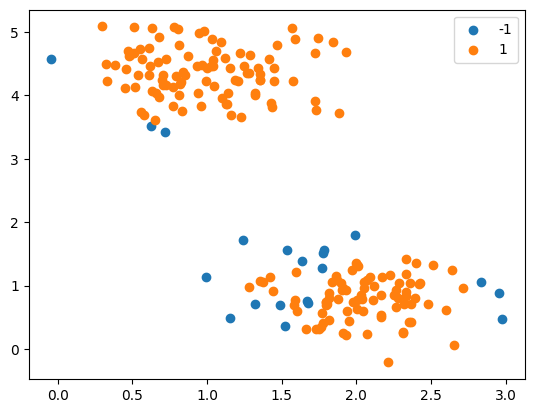

In [83]:
inne = INNE(n_estimators=10, phai=10)
inne.fit(X)
labels = inne.predict(X, contamination=0.1)
unique_labels = np.unique(labels)
for label in unique_labels:
    plt.scatter(X[labels == label, 0], X[labels == label, 1], label=label)
plt.legend()